In [27]:
import pandas as pd
import numpy as np
%pylab inline
from sklearn.preprocessing import MinMaxScaler as StandardScaler
import seaborn as sns
pyplot.style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


In [53]:
too = pd.read_csv('311.csv',index_col=0).set_index('Neighborhood',drop=True)
rent = pd.read_csv('rent.csv',index_col=0)
subway = pd.read_csv('subway.csv',index_col=0)
crime = pd.read_csv('crime.csv',index_col=0).set_index('Neighborhood',drop=True)
venues = pd.read_csv('venues.csv').set_index('Neighborhood', drop = True)

In [54]:
venues['venue_count'] = venues['venue_count'].max() - venues['venue_count']
venues['category_count'] = venues['category_count'].max() - venues['category_count']

In [55]:
subway['subway_dist'] = (subway.subway_dist * 0.5/0.01).round(2) #convert to miles

In [56]:
lat_conv = 0.69/0.01
long_conv = 0.52/0.01
times_square= [40.7580, -73.9855]

In [57]:
times_square

[40.758, -73.9855]

In [58]:
too['dist_timessq'] = np.sqrt(((too.Longitude - times_square[1])*long_conv)**2 + ((too.Latitude - times_square[0])*lat_conv)**2).round(1)

In [59]:
rent['imputed'] = rent['imputed'].astype(int)

In [60]:
too = too[too.Borough != 'Staten Island']
frames = [too,rent,subway,crime, too,venues]
fields = ['Calls','imputed','subway_dist','Arrests','dist_timessq','venue_count']

# for frame, field in zip(frames,fields):
#     frame[field] = StandardScaler().fit_transform(frame[[field]])
too = too.reset_index().groupby(['Neighborhood']).mean()

In [61]:
merged = frames[0][[fields[0], 'Borough']]
# merged = merged.reset_index().groupby(['Neighborhood']).mean()
for frame,field in zip(frames[1:],fields[1:]):
    merged = pd.merge(merged, frame[field].to_frame(), left_index=True, right_index=True, how='inner')

In [62]:
merged = merged.reset_index().groupby(['Neighborhood','Borough']).mean().reset_index().set_index('Neighborhood')

In [63]:
merged.columns = ['Borough', '311 Calls','Rent 1BD','Average Distance to Subway (miles)','Crime','Dist. from Midtown (miles)','Venue density']

In [64]:
merged = merged.drop('311 Calls',axis=1)

In [65]:
def is_pareto_efficient(costs):
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        is_efficient[i] = np.all(np.any(costs[:i]>c, axis=1)) and np.all(np.any(costs[i+1:]>c, axis=1))
    return is_efficient

In [66]:
fields=['Average Distance to Subway (miles)','Rent 1BD', 'Crime']

In [67]:
pareto_efficient_2 = is_pareto_efficient(merged[fields].values)
pareto_efficient = is_pareto_efficient(merged.values)

In [70]:
merged.round(2).to_csv('merged.csv')

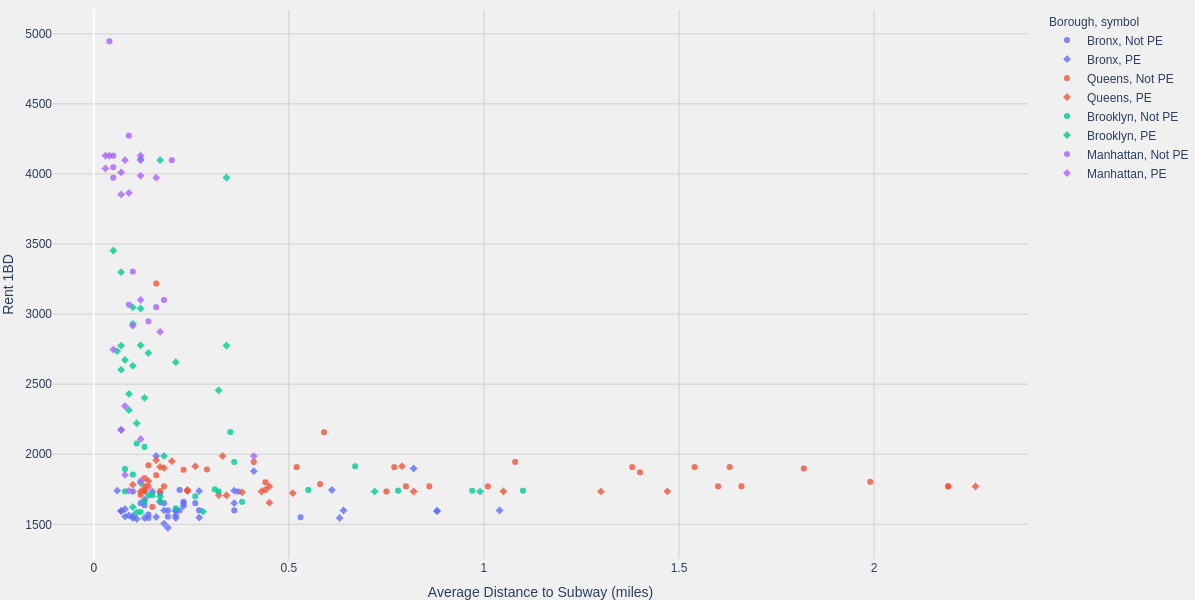

In [43]:
import plotly.express as px

fig = px.scatter(merged.reset_index(), x= fields[0],y = fields[1],size_max=1,color='Borough',
                    opacity=0.8, hover_name='Neighborhood',symbol=[{False:'Not PE', True:'PE'}[x] for x in pareto_efficient])


fig.update_layout(
    scene = dict(
                    xaxis = dict(nticks=4, range=[-0.01,0.5],),
                     yaxis = dict(nticks=4, range=[-0.01,0.5],),),
    paper_bgcolor= '#f0f0f0',
    xaxis = dict(gridcolor='#cfcfcf'),
    yaxis = dict(gridcolor='#cfcfcf'),
    plot_bgcolor= '#f0f0f0',
    height=600,
    width=800,
    margin=dict(r=0, l=0, b=10, t=10))

fig.show()

In [44]:
pareto_borough = (merged[pareto_efficient].Borough.value_counts().to_frame()/merged.Borough.value_counts().to_frame()*100).astype(int).reset_index()

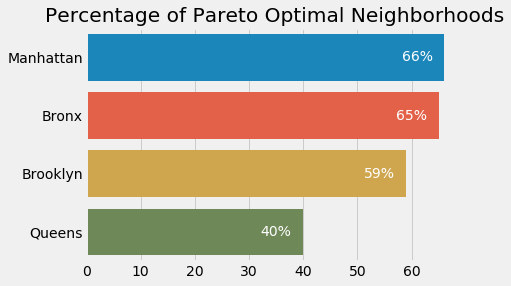

In [45]:
ax = sns.barplot(y='index',x='Borough',data = pareto_borough.sort_values('Borough', ascending=False))


rects = ax.patches

for rect in rects:
    width = rect.get_width()
    if width ==0:
        ax.text(width+5, rect.get_y() + rect.get_height() / 2 +0.12, '{}%'.format(int(width)),
            ha='center', va='bottom',color='black')
    else:
        
        ax.text(width-5, rect.get_y() + rect.get_height() / 2 +0.12, '{}%'.format(int(width)),
                ha='center', va='bottom',color='white')
    
ylabel('')
xlabel('')
title('Percentage of Pareto Optimal Neighborhoods');
savefig('fig/percentage_pareto.png',bbox_inches='tight')
savefig('fig/percentage_pareto.pdf',bbox_inches='tight')


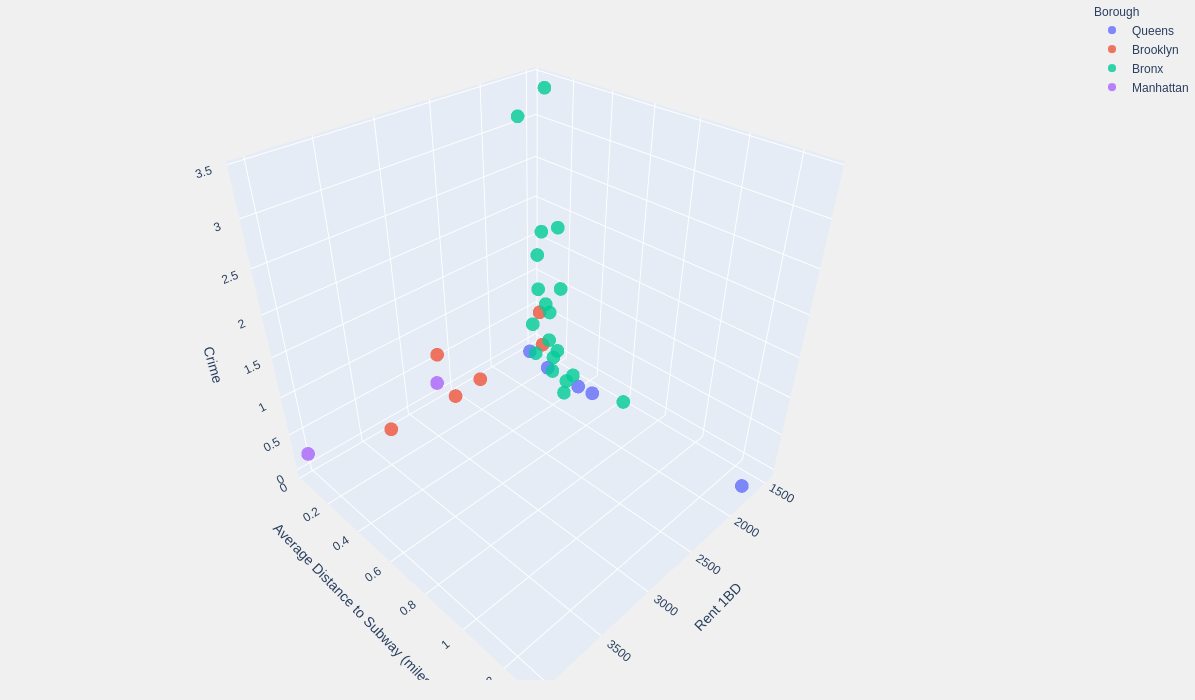

In [46]:
import plotly.express as px

fig = px.scatter_3d(merged[pareto_efficient_2].reset_index(), x= 'Rent 1BD',y='Average Distance to Subway (miles)',z = 'Crime',size_max=1,color='Borough',
                    opacity=0.8,hover_name='Neighborhood')


fig.update_layout(
    height=700,
    width=800,
    margin=dict(r=0, l=0, b=20, t=0),
     paper_bgcolor= '#f0f0f0',)

fig.write_html('../../semodi.github.io/_includes/pareto_3d.html',include_mathjax=False, include_plotlyjs='cdn')
fig.show()


In [47]:
radar_data = merged

In [48]:
num_col = [col for col in merged.columns if np.issubdtype(merged[col].dtype, np.number)]

In [49]:
radar_data.loc[:,num_col] = 1 - StandardScaler().fit_transform(radar_data.loc[:,num_col])

In [50]:
radar_data.to_csv('normalized_data.csv')

In [24]:
radar_data.loc[:,num_col]=radar_data.loc[:,num_col]**2

In [25]:
radar_data_pareto = radar_data[pareto_efficient].groupby('Borough').mean()
radar_data = radar_data.groupby('Borough').mean()

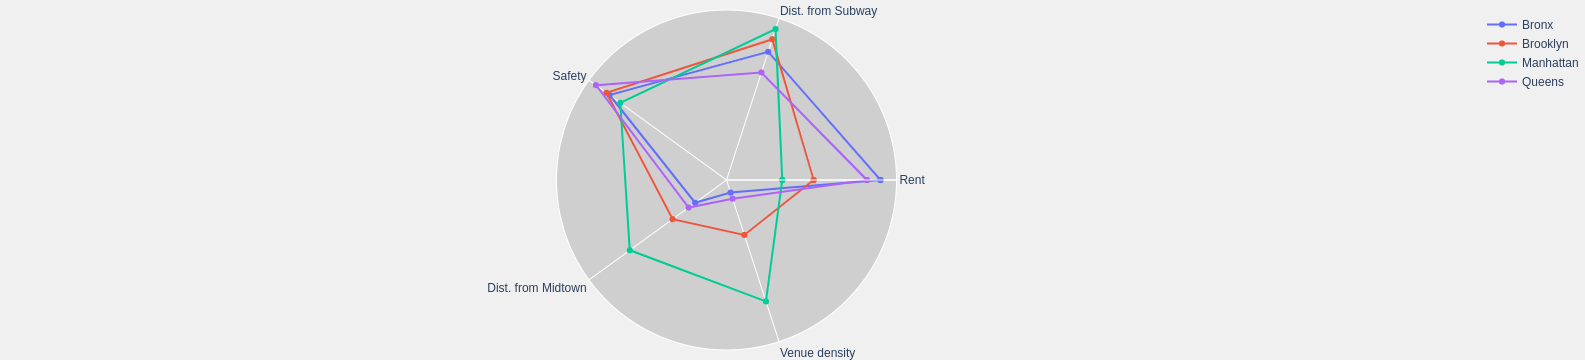

In [40]:
import plotly.graph_objects as go
import plotly.io as pio



categories =  [col for col in merged.columns if not col=='Borough']
categories = ['Rent',
 'Dist. from Subway',
 'Safety',
 'Dist. from Midtown',
 'Venue density']
fig = go.Figure()

for idx, val in radar_data_pareto.iterrows():

    fig.add_trace(go.Scatterpolar(
          r=val.tolist() + [val.tolist()[0]],
          theta=categories + [categories[0]],
          fill='none',
          name=idx,
          hoverinfo='none'
    ))

# for idx, val in radar_data_pareto.iterrows():
#     fig.add_trace(go.Scatterpolar(
#           r=val,
#           theta=categories,
# #           fill='toself',
#           name=idx,
#           line=dict(dash='dash')
#     ))
    
fig.update_layout(
  polar=dict(
    bgcolor= '#cfcfcf',
    radialaxis=dict(
      visible=True,
      range=[0, 1],
      tickvals=[]
      
    )),
      paper_bgcolor= '#f0f0f0',
    xaxis = dict(gridcolor='#cfcfcf'),
    yaxis = dict(gridcolor='#cfcfcf'),
    
    height=300,
    width=600,
    margin=dict(r=0, l=0, b=10, t=10),
  showlegend=True
)
# fig.write_html('fig/pareto_radial.html')
pio.write_html(fig, file='../../semodi.github.io/_includes/pareto_radial_test.html',include_mathjax=False, include_plotlyjs='cdn')

fig.show()

In [27]:
import numpy as np 

In [28]:
r = np.random.rand(200)
theta = np.random.rand(200)*2*np.pi

In [29]:
x = r*np.sin(theta)+1
y = r*np.cos(theta)+1

In [30]:
np.stack([x,y]).shape

(2, 200)

In [31]:
pe = is_pareto_efficient(np.stack([x,y]).T)

In [32]:
x_pe = x[pe]
y_pe = y[pe]

In [33]:
order = np.argsort(x_pe)
x_pe = x_pe[order]
y_pe = y_pe[order]

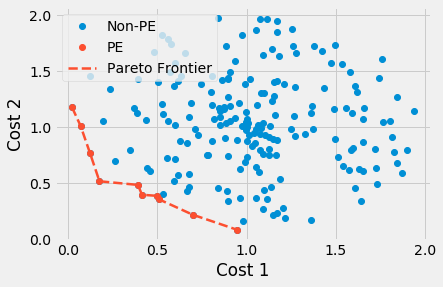

In [76]:
plot(x,y,ls ='',marker='o',label='Non-PE')
plot(x[pe],y[pe],ls ='',marker='o',label='PE')
plot(x_pe,y_pe,ls ='--',marker='',label='Pareto Frontier',color='C1',lw=2.5)
xlabel('Cost 1')
ylabel('Cost 2')
legend()
savefig('pareto_example.pdf',bbox_inches='tight')
# savefig('pareto_example.png',bbox_inches='tight')